📂 Loading data from: /Users/przemo/Coding/document data retrieval/content
✅ Loaded 581 documents across 31 categories.
⏳ Tokenizing data...
🏗️ Initializing DistilBERT...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'cla


🚀 Starting Training...
Epoch 1/10
29/29 [==============================] - 107s 4s/step - loss: 3.3497 - accuracy: 0.1293 - val_loss: 3.1950 - val_accuracy: 0.1795
Epoch 2/10
29/29 [==============================] - 88s 3s/step - loss: 3.0215 - accuracy: 0.2543 - val_loss: 2.8654 - val_accuracy: 0.2564
Epoch 3/10
29/29 [==============================] - 92s 3s/step - loss: 2.6748 - accuracy: 0.3341 - val_loss: 2.5330 - val_accuracy: 0.3077
Epoch 4/10
29/29 [==============================] - 97s 3s/step - loss: 2.2751 - accuracy: 0.4375 - val_loss: 2.2682 - val_accuracy: 0.3846
Epoch 5/10
29/29 [==============================] - 97s 3s/step - loss: 1.9024 - accuracy: 0.5366 - val_loss: 2.0536 - val_accuracy: 0.4188
Epoch 6/10
29/29 [==============================] - 90s 3s/step - loss: 1.5571 - accuracy: 0.6164 - val_loss: 1.7769 - val_accuracy: 0.5128
Epoch 7/10
29/29 [==============================] - 93s 3s/step - loss: 1.2349 - accuracy: 0.7565 - val_loss: 1.6169 - val_accuracy: 0.

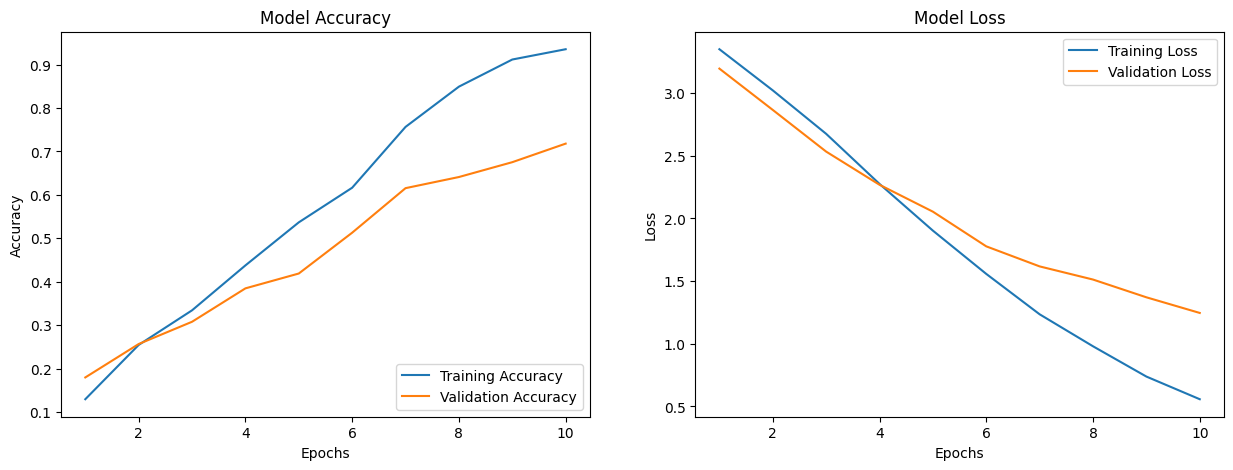

4/4 [==============================] - 7s 2s/step


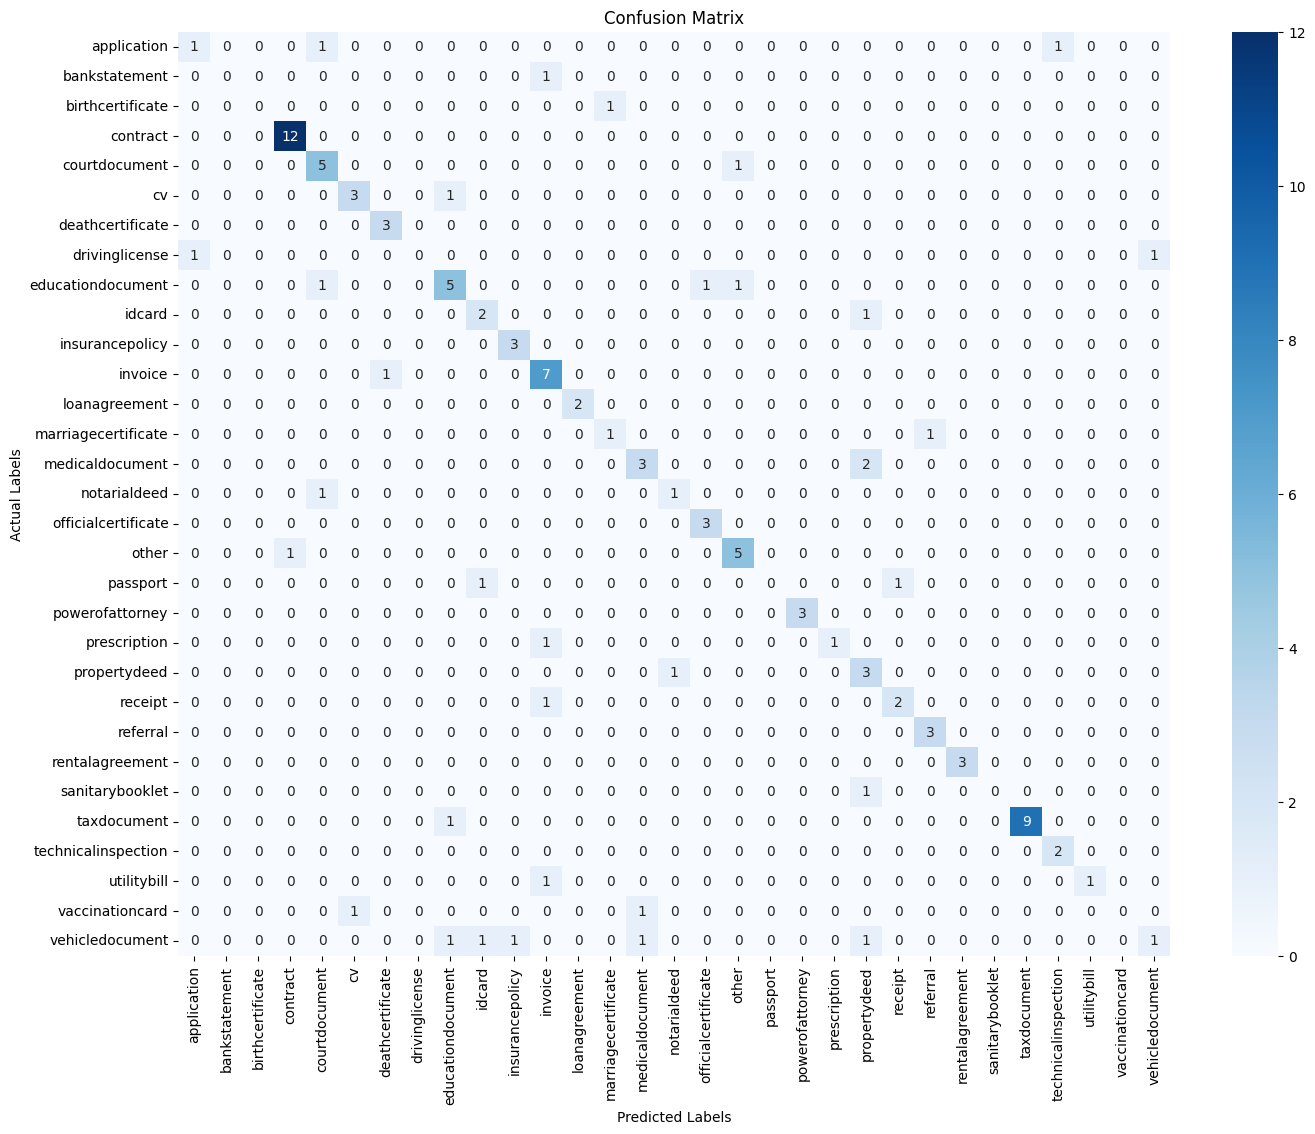


🔧 Converting to TFLite (Flutter compatibility mode)...


INFO:tensorflow:Assets written to: /var/folders/t6/7gm1y_yj5831dq3xh1b21y8w0000gp/T/tmpjiipqr2p/assets


INFO:tensorflow:Assets written to: /var/folders/t6/7gm1y_yj5831dq3xh1b21y8w0000gp/T/tmpjiipqr2p/assets
W0000 00:00:1768129583.122066 5167281 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1768129583.122413 5167281 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2026-01-11 12:06:23.123564: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/t6/7gm1y_yj5831dq3xh1b21y8w0000gp/T/tmpjiipqr2p
2026-01-11 12:06:23.137574: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2026-01-11 12:06:23.137592: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/t6/7gm1y_yj5831dq3xh1b21y8w0000gp/T/tmpjiipqr2p
2026-01-11 12:06:23.213321: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2026-01-11 12:06:24.290206: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/t6/7gm1y_yj

✨ SUCCESS! Model saved as document_type_classifier.tflite


In [4]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

# --- 1. PATH CONFIGURATION ---
# Assumes the notebook is in a subfolder; goes up one level to reach project root
BASE_DIR = Path.cwd().parent 
DATA_ROOT = BASE_DIR / "content"
LABEL_ROOT = BASE_DIR / "synthetic_dataset" / "type"

TFLITE_OUTPUT = "document_type_classifier.tflite"
LABELS_OUTPUT = "document_type_labels.txt"

# Model Parameters
MODEL_ID = "distilbert-base-multilingual-cased"
MIN_SAMPLES_PER_CLASS = 2
MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 10 

# --- 2. VISUALIZATION FUNCTIONS ---
def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 5))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def plot_cm(model, val_encodings, val_labels, label_names):
    # Generate predictions
    preds = model.predict(val_encodings)
    pred_labels = np.argmax(preds.logits, axis=1)
    cm = confusion_matrix(val_labels, pred_labels)
    
    plt.figure(figsize=(16, 12))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

# --- 3. DATA LOADING ---
def load_data():
    texts, labels = [], []
    print(f"📂 Loading data from: {DATA_ROOT}")
    if not DATA_ROOT.exists():
        print("❌ ERROR: Data folder not found!")
        return [], []
        
    for text_file in DATA_ROOT.rglob("*.txt"):
        rel_path = text_file.relative_to(DATA_ROOT)
        label_file = LABEL_ROOT / rel_path
        if label_file.exists():
            content = text_file.read_text(encoding="utf-8").strip()
            label = label_file.read_text(encoding="utf-8").strip().lower()
            if content and label:
                texts.append(content)
                labels.append(label)
    return texts, labels

# --- 4. MAIN PIPELINE ---
texts, labels = load_data()
counts = Counter(labels)
# Filter classes with too few samples
valid_classes = [cls for cls, count in counts.items() if count >= MIN_SAMPLES_PER_CLASS]

filtered_texts = [t for t, l in zip(texts, labels) if l in valid_classes]
filtered_labels = [l for t, l in zip(texts, labels) if l in valid_classes]

print(f"✅ Loaded {len(filtered_texts)} documents across {len(valid_classes)} categories.")

# Label Encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(filtered_labels)
num_labels = len(label_encoder.classes_)

# Save labels for Flutter app usage
with open(LABELS_OUTPUT, "w", encoding="utf-8") as f:
    f.write("\n".join(label_encoder.classes_))

# Train/Validation Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    filtered_texts, y, test_size=0.20, random_state=42, stratify=y
)

# Tokenization
print("⏳ Tokenizing data...")
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_ID)
train_encodings = dict(tokenizer(train_texts, padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="tf"))
val_encodings = dict(tokenizer(val_texts, padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="tf"))

# Model Initialization
print("🏗️ Initializing DistilBERT...")
model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_ID, num_labels=num_labels, from_pt=True)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=3e-5)
model.compile(
    optimizer=optimizer, 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

# TRAINING
print("\n🚀 Starting Training...")
history = model.fit(
    x=train_encodings,
    y=train_labels,
    validation_data=(val_encodings, val_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

# VISUALIZE RESULTS
plot_learning_curves(history)
plot_cm(model, val_encodings, val_labels, label_encoder.classes_)

# --- 5. TFLITE CONVERSION ---
print("\n🔧 Converting to TFLite (Flutter compatibility mode)...")
@tf.function(input_signature=[tf.TensorSpec([1, MAX_LEN], tf.int32, name="input_ids")])
def serving_fn(input_ids):
    return model(input_ids, training=False)

converter = tf.lite.TFLiteConverter.from_concrete_functions([serving_fn.get_concrete_function()], model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.optimizations = [] # Disable optimizations to prevent opcode version issues in Flutter
converter.target_spec.supported_types = [tf.float32]

tflite_model = converter.convert()
with Path(TFLITE_OUTPUT).open("wb") as f:
    f.write(tflite_model)

print(f"✨ SUCCESS! Model saved as {TFLITE_OUTPUT}")


Analyzing your Confusion Matrix, it's clear that the classifier is performing remarkably well given the complexity of having 31 different document categories. The strong diagonal line indicates that for most classes, the model is predicting the document type correctly.

Key Takeaways from the Matrix:
Best Performing Categories: Classes like contract (12 correct), educationdocument (8 correct), taxdocument (8 correct), and invoice (7 correct) show high accuracy with very few misclassifications.

Minor Confusions:

courtdocument is occasionally mistaken for contract (1 instance). This makes sense as legal language can be very similar.

idcard was once confused with cv, likely due to both containing personal names and profile-like information.

medicaldocument seems to be a slight "magnet" for errors; documents like vaccinationcard and medicaldocument itself (predicted as referral) show some overlap in medical terminology.

Data Sparsity: Many categories (like bankstatement or birthcertificate) have very few samples in this validation set (only 1). While the model got them right, more data would be needed to confirm its stability for these specific types.